This lab applies the least squares method to estimate parameters that are not linear model coefficients. As a result the goodness of fit test using the value of minimum $\chi^2$ is not exact.

Model: $E[V_i] = \alpha t_i \cos(\beta t_i)$

$V_i$ are gaussian distributed with standard deviation $\sigma_i$. The data is generated using random numbers with a defined seed, so the results are reproducable, if the entire notebook is rerun (Kernel -> restart & run all)

Some cells are missing code that needs to be added to complete the lab.

In [1]:
# cell #1: generic setup
import numpy as np
from scipy import stats, optimize
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# cell #2: define basic parameters, the model, and create a reference dataset 

#set the seed for random number generation, so the results are reproducable
np.random.seed(seed=123456)

# define the parameters of the problem
n = 8 # number of data points
trange = [0.,4.] # range within t_i values are drawn
srange = [0.2,1.0] # corresponding range of sigma_i values
a_true = 1.5 # true value for the parameter a
b_true = 2.0 # true value for the parameter b

# Our model:
def model(a,b,t):
    return a*t*np.cos(b*t)

def get_data():
    dt = (trange[1]-trange[0])/n # distance between t values
    t = np.arange(trange[0]+dt,trange[1]+0.001,dt) # 0.001 added to ensure exactly n points in arange
    sigma = (t-trange[0])/(trange[1]-trange[0])*(srange[1]-srange[0]) + srange[0]
    v = model(a_true,b_true,t) + stats.norm.rvs(scale=sigma)
    return t, v, sigma

# Reference data:
t, v, sigma = get_data()

In [3]:
# cell #3: calculate chi^2 for particular choice of parameter values

# input: args: [a,b]

def chi2(args):
    a = args[0]
    b = args[1]
    residuals = (v - model(a, b, t))
    value = np.sum((residuals / sigma) ** 2)
    return value

chi2([a_true,b_true])

6.470854815559939

In [4]:
# cell #4: find best estimates for parameters using least squares for the reference dataset

# start with a guess and find the parameters that minimize the chi2 function
guess = [1.3,1.3]
# the optimize.minimize method calls the chi2 function several times to find
# parameters that produce the minimum value of that function 
# it starts from the parameters stored in guess

result = optimize.minimize(chi2,guess)
a_est = result.x[0]; b_est = result.x[1]

# sometimes the optimizer will not succeed. In those cases, an alternative guess might help
success = result.success

# the one standard deviation uncertainties are estimated by the second derivatives of the function
# since we are using chi2 instead of log-likelihood, factors of 2 needs to be included
sig_a = np.sqrt(result.hess_inv[0,0]*2.)
sig_b = np.sqrt(result.hess_inv[1,1]*2.)
rho = result.hess_inv[0,1]*2./sig_a/sig_b

print("Optimizer success =",success)

print("Parameter estimates:")
print("  a-hat = %5.2f +/- %5.2f" %(result.x[0],sig_a))
print("  b-hat = %5.2f +/- %5.2f" %(result.x[1],sig_b))
print("Correlation coeff = %5.2f" %(rho))

print("chi^2 min = %5.2f" %(chi2([a_est,b_est])))
print("chi^2 true = %5.2f" %(chi2([a_true,b_true])))

Optimizer success = True
Parameter estimates:
  a-hat =  1.75 +/-  0.16
  b-hat =  2.03 +/-  0.03
Correlation coeff = -0.01
chi^2 min =  3.13
chi^2 true =  6.47


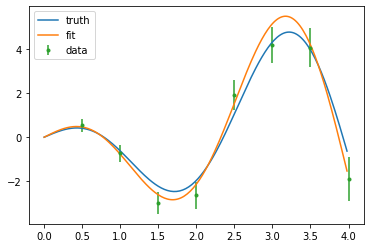

In [5]:
# cell #5: compare visually the data and the model

fig, axes = plt.subplots()
tarray = np.arange(trange[0],trange[1],0.02)
varray = model(a_true,b_true,tarray)
vfit = model(a_est,b_est,tarray)
axes.plot(tarray,varray,label="truth")
axes.plot(tarray,vfit,label="fit")
axes.errorbar(t,v,yerr=sigma,marker='.',linestyle='none',label='data')
plt.legend();

The fit closely follows the data, so we can conclude that the optimization process succeeded in finding parameter values that describe the measured data. The truth and fit are slightly different, but this is expected and reflects the uncertainty in the measurements.

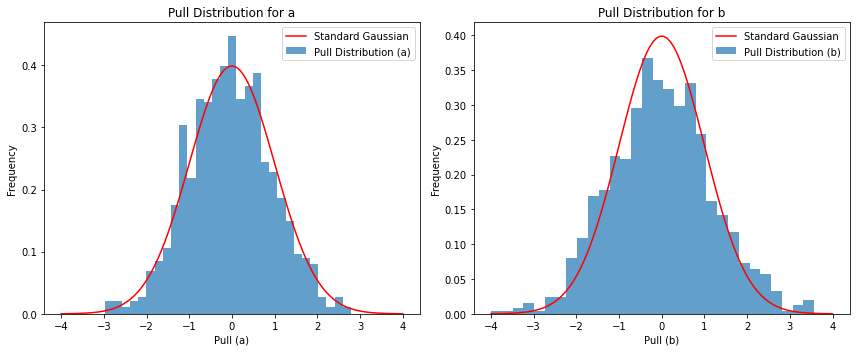

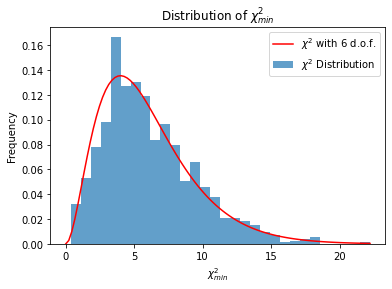

Pull (a): mean = -0.05, std = 0.97
Pull (b): mean = -0.01, std = 1.19


In [6]:
# cell #6: consider 1000 replications of the experiment

n_replications = 1000
a_estimates, b_estimates, chi2_min_values = [], [], []

for _ in range(n_replications):
    t, v, sigma = get_data()
    
    result = optimize.minimize(chi2, guess)
    
    if result.success:
        a_estimates.append(result.x[0])
        b_estimates.append(result.x[1])
        chi2_min_values.append(chi2(result.x))

a_estimates = np.array(a_estimates)
b_estimates = np.array(b_estimates)

pull_a = (a_estimates - a_true) / sig_a
pull_b = (b_estimates - b_true) / sig_b

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(pull_a, bins=30, density=True, alpha=0.7, label='Pull Distribution (a)')
x = np.linspace(-4, 4, 100)
axes[0].plot(x, stats.norm.pdf(x, 0, 1), label='Standard Gaussian', color='red')
axes[0].legend()
axes[0].set_title('Pull Distribution for a')
axes[0].set_xlabel('Pull (a)')
axes[0].set_ylabel('Frequency')

axes[1].hist(pull_b, bins=30, density=True, alpha=0.7, label='Pull Distribution (b)')
axes[1].plot(x, stats.norm.pdf(x, 0, 1), label='Standard Gaussian', color='red')
axes[1].legend()
axes[1].set_title('Pull Distribution for b')
axes[1].set_xlabel('Pull (b)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

plt.hist(chi2_min_values, bins=30, density=True, alpha=0.7, label=r'$\chi^2$ Distribution')
df = n - 2  #degrees of freedom
x = np.linspace(0, max(chi2_min_values), 100)
plt.plot(x, stats.chi2.pdf(x, df), label=r'$\chi^2$ with %d d.o.f.' % df, color='red')
plt.title(r'Distribution of $\chi^2_{min}$')
plt.xlabel(r'$\chi^2_{min}$')
plt.ylabel('Frequency')
plt.legend()
plt.show()

mean_pull_a = np.mean(pull_a)
std_pull_a = np.std(pull_a)
mean_pull_b = np.mean(pull_b)
std_pull_b = np.std(pull_b)

print(f"Pull (a): mean = {mean_pull_a:.2f}, std = {std_pull_a:.2f}")
print(f"Pull (b): mean = {mean_pull_b:.2f}, std = {std_pull_b:.2f}")

The means of the pull distributions should be close to 0, and their standard deviations should be close to 1 because the estimates are unbiased and their uncertainties are correctly modeled.

A mean value close to zero shows the parameter estimates are unbiased.

When the standard deviation is approximately 1 then the estimated uncertainties accurately reflect the actual variability in the estimates

The $\chi^2_{min}$ value can be used to assess how well the model fits the data by comparing it to a $\chi^2$ distribution with (n-2) degrees of freedom.

If the $\chi^2_{min}$ value is much larger than expected for the $\chi^2$ distribution, then the model is probably inadequate or the measurement uncertainties might be underestimated.

If the $\chi^2_{min}$ value is much smaller than expected for the $\chi^2$ distribution, then there's probably overfitting or the measurement uncertainties were overestimated.